In [404]:
#coding:utf8
import pandas as pd 
import numpy as np
import tensorflow as tf
import keras_tuner as kt
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers, metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

In [399]:
def load_data(em_data = True, veh_data = True, air_data = True):
    args = []
    if em_data:
        EU_em_df = pd.read_excel('Data/EU_em.xlsx',engine='openpyxl')
        EU_em_annual_df = pd.read_csv('Data/EU_em_annual.csv',)
        UK_em_df = pd.read_excel('Data/UK_em.ods', nrows = 14)
        US_em_df = pd.read_excel('Data/US_em.xlsx',engine='openpyxl')
        # Emissions data Processing
        EU_em_df = EU_em_df.set_index('Month')
        EU_em_annual_df = EU_em_df.groupby(np.arange(len(EU_em_df))//(12)).sum()
        EU_em_annual_df.index = np.linspace(1973, 2021, EU_em_annual_df.shape[0], dtype=np.int32)
        UK_em_df = UK_em_df.transpose()
        UK_em_df.columns = UK_em_df.iloc[0, :]
        UK_em_df = UK_em_df.drop('Year')
        US_em_df = US_em_df.transpose()
        US_em_df.columns = US_em_df.iloc[0, :]
        US_em_df = US_em_df.replace('+', 0)
        US_em_df = US_em_df.drop('Year')
        args += [EU_em_df, EU_em_annual_df, UK_em_df, US_em_df]
    if veh_data:
        EU_veh_df = pd.read_csv('Data/EU_veh.csv')
        UK_veh_df = pd.read_excel('Data/UK_veh.ods', nrows= 27)
        US_veh_df = pd.read_excel('Data/US_veh.xlsx', nrows = 9)
        US_veh_df = US_veh_df.transpose()
        US_veh_df.columns = US_veh_df.iloc[0, :]
        US_veh_df = US_veh_df.drop('Model Year')
        args += [EU_veh_df, UK_veh_df, US_veh_df]
    if air_data:
        # Secondary Data 
        # Air pollution
        # UK 1970-2019/2022
        UK_nox_annual_df = pd.read_csv('Data/Figure06_NOx_time_series.csv')
        UK_pm_all_annual_df = pd.read_csv('Data/Figure03_PM_time_series.csv')
                
        # USA Since 1970-2020, plz Access through column id(numbers)
        USA_nox_annual_df = pd.read_csv('Data/US_nox_em_time_series.csv') # National Emissions Totals (thousands of tons)
        USA_pm_10_annual_df = pd.read_csv('Data/US_pm10_year.csv')        #
        USA_pm_2_5_annual_df = pd.read_csv('Data/US_pm2_5_year.csv')
        
        USA_pm_2_5_annual_df = USA_pm_2_5_annual_df.transpose()
        USA_pm_10_annual_df = USA_pm_10_annual_df.transpose()
                
        # OCED DATA
        OCED_PM10_df = pd.read_excel('Data/PM10_ROAD_OCED_WORLD_DATA.xlsx')
        OCED_NOX_df = pd.read_excel('Data/NOX_ROAD_OCED_WORLD_DATA.xlsx')
        OCED_PM2_5_df = pd.read_excel('Data/PM2_5_ROAD_OCED_WORLD_DATA.xlsx')
    
    args += [UK_nox_annual_df,UK_pm_all_annual_df,USA_pm_10_annual_df,USA_pm_2_5_annual_df,USA_nox_annual_df,OCED_PM10_df,OCED_NOX_df,OCED_PM2_5_df]
        
    return args

def process_data(X, y, split_point):
    X_norm, X_attrs, y_norm, y_attrs = normalise(X, y)
    split_point = int(X_norm.shape[0] *split_point)
    y_norm = np.roll(y_norm, -time_step)
    nrows = X_norm.shape[0]
    samples = X_norm.shape[1]
    X_norm = np.repeat(X_norm, data_memory, 0).reshape(nrows, data_memory, samples)
    x_train, x_test, y_train, y_test = train_test_split(X_norm, y_norm, split_point)
    return x_train, x_test, y_train, y_test, nrows, samples, X_norm, y_norm, X_attrs, y_attrs

def normalise(X, y):
    X_attrs = np.zeros((X.shape[-1], 2))
    y_attrs = np.zeros((y.shape[-1], 2))
    for i in range(X.shape[-1]):
        X_attrs[i, :] = [np.mean(X[:, i]), np.var(X[:, i])]
        X[:, i] = (X[:, i] - np.mean(X[:, i]))/np.var(X[:, i])**0.5
    for i in range(y.shape[-1]):
        y_attrs[i, :] = [np.mean(y[:, i]), np.var(y[:, i])]
        y[:, i] = (y[:, i] - np.mean(y[:, i]))/np.var(y[:, i])**0.5  
    return X, X_attrs, y, y_attrs

def train_test_split(X, y, split_point):
    x_train = X[:split_point, :, :]
    x_test = X[split_point:, :, :]
    y_train = y[:split_point]
    y_test = y[split_point:]
    return x_train, x_test, y_train, y_test
        
def create_model(layers, input_shape, print_summary):
    model = keras.Sequential(layers)
    model.build(input_shape=input_shape)
    model.compile(loss='mse', optimizer='adam')
    if print_summary:
        model.summary()
    return model

def plot_pred(y, y_pred, plot_range):
    t = np.linspace(plot_range[0], plot_range[1], plot_range[1] - plot_range[0])
    plt.plot(t, y[plot_range[0] : plot_range[1]], 'g', t, y_pred[plot_range[0]: plot_range[1]], 'r')

def run_model(X, y, data_memory, epochs, batch_size, model_des, split_point, plot_pred_bool, plot_range, print_summary):
    x_train, x_test, y_train, y_test, nrows, samples, X_norm, y_norm, X_attrs, y_attrs = process_data(X, y, split_point)
    input_shape = (x_train.shape[0], data_memory, samples)
    model = create_model(model_layer, input_shape, print_summary)
    history = model.fit(x_train, y_train, validation_split = 0.1, epochs= epochs , batch_size=batch_size)
    y_pred_norm = np.concatenate((model.predict(x_train[:, :, :]), model.predict(x_test[:, :, :])))
    y_pred_norm = np.roll(y_pred_norm, 1, axis = 1)
    y_pred = np.roll(y_pred_norm *y_attrs[:, 1]**0.5 + y_attrs[:, 0] , 0)
    mse = metrics.MeanSquaredError()
    mse.update_state(y_norm, y_pred_norm)
    test_loss = mse.result().numpy()
    print(test_loss)
    train_loss = history.history['loss'][-1]
    val_loss = history.history['val_loss'][-1]
    model_performance = [time_step, data_memory, samples, model_des, epochs, batch_size, train_loss, val_loss, test_loss]
    df_model = pd.DataFrame(model_performance).transpose()
    df_model.columns = df_model_columns
    df_model.to_csv('model_performance.csv', mode = 'a', header= False)
    if plot_pred_bool:
        plot_pred(y, y_pred, plot_range)
    return y, y_pred


In [3]:
args = load_data()
EU_em_df, EU_em_annual_df, UK_em_df, US_em_df, EU_veh_df, UK_veh_df, US_veh_df, UK_nox_annual_df,UK_pm_all_annual_df,USA_pm_10_annual_df,USA_pm_2_5_annual_df,USA_nox_annual_df,OCED_PM10_df,OCED_NOX_df,OCED_PM2_5_df = args

C:\Apps\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [393]:
time_step = 1
data_memory = 5
epochs = 20
batch_size = 1
split_point = 0.9
df_model_columns =  ['time_step', 'data_memory', 'samples', 'layers', 'epochs', 'batch_size', 'training_loss', 'val_loss', 'test_loss']
model_des = 'D32, GRU32, GRU32 D1'
model_layer = [layers.Dense(32, activation= 'sigmoid'),
                layers.GRU(32,activation= 'softsign', recurrent_activation = 'relu', recurrent_dropout = 0.1, dropout = 0.1, return_sequences=False),
                layers.Dense(2)]

model_layer = [layers.LSTM(2, activation="linear", return_sequences=True),
               layers.LSTM(2, activation='linear', return_sequences=False),
               layers.Dense(8, activation='linear'),
               layers.Dense(2, activation='linear')]
               
               
# sigmoid, softsign, relu 
# activation='softsign', recurrent_activation='relu'
plot_range = [0]
plot_range += [plot_range[0] + 27]
plot_pred_bool = False  
print_summary = False
#model_df = pd.DataFrame(model_performance).transpose()
#model_df.to_csv('model_performance.csv')
EU_em_X, EU_em_y = np.split(EU_em_df.to_numpy(), [11], 1)
UK_em_X, UK_em_y = np.split(UK_em_df.to_numpy(dtype=np.float64), [13], 1)
US_em_X, US_em_y, a = np.split(US_em_df.to_numpy(dtype=np.float64), [45,46], 1)
EU_veh_X = EU_veh_df.to_numpy()
EU_veh_y = np.roll(np.sum(EU_veh_X[:, 1:3], axis =1), time_step)
EU_veh_y[:time_step] = 0
EU_veh_y = np.array([EU_veh_y]).transpose()
UK_veh_X = UK_veh_df.to_numpy(dtype=np.float64)
UK_veh_y = np.array([np.sum(UK_veh_X[:, 3:7], axis = 1)]).transpose()
US_veh_X, US_veh_y = np.split(US_veh_df.to_numpy(dtype=np.float64), [8], 1)
EU_em_annual_X, EU_em_annual_y = np.split(EU_em_df.groupby(np.concatenate((np.repeat(np.linspace(1973, 2020, 48, dtype = np.int64), 12), 2021 *np.ones((10), dtype=np.int64)), axis = 0)).sum().to_numpy(), [11], 1)

EU_X = np.concatenate((EU_em_annual_X[-13:-2, :], EU_veh_X), axis = 1)[:, 1:]
EU_y = np.concatenate((EU_em_annual_y[-13: -2, :], EU_veh_y), axis = 1)

UK_X = np.concatenate((UK_em_X[4:, :], UK_veh_X[:-1, :]), axis = 1)[:, 1:]
UK_y = np.concatenate((UK_em_y[4:], UK_veh_y[: -1]), axis = 1)

US_X = np.concatenate((US_em_X[2:, :15], US_veh_X), axis = 1)
US_y = np.concatenate((US_em_y[2:, :15], US_veh_y), axis = 1)


In [ ]:
model_layer = [layers.Dense(32, activation= 'sigmoid'),
                layers.GRU(32,activation= 'softsign', recurrent_activation = 'relu', recurrent_dropout = 0.1, dropout = 0.1, return_sequences=False),
                layers.Dense(2)]
def combined_model(em_X, veh_X, em_y, veh_y):
    X = np.concatenate((em_X, veh_X), axis = 1)
    y = np.concatenate((em_y, veh_y), axis = 1)
    y, y_pred = run_model(X, y, data_memory, epochs, batch_size, model_des, split_point, plot_pred_bool, plot_range, print_summary)
    t = np.linspace(2010, 2020, 11)
    y = np.concatenate((em_y, EU_veh_y), axis = 1)
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex= True)
    ax1.plot(t, y[:, 0], 'g', t, y_pred[:, 0], 'r')
    ax2.plot(t, y[:, 1], 'g', t, y_pred[:, 1], 'r')

Epoch 1/50
8/8 [==============================] - 3s 53ms/step - loss: 0.6038 - val_loss: 1.3161
Epoch 2/50
8/8 [==============================] - 0s 4ms/step - loss: 0.3779 - val_loss: 1.6108
Epoch 3/50
8/8 [==============================] - 0s 6ms/step - loss: 0.2523 - val_loss: 1.8288
Epoch 4/50
8/8 [==============================] - 0s 6ms/step - loss: 0.2206 - val_loss: 1.5668
Epoch 5/50
8/8 [==============================] - 0s 5ms/step - loss: 0.1457 - val_loss: 1.2568
Epoch 6/50
8/8 [==============================] - 0s 5ms/step - loss: 0.1542 - val_loss: 1.0921
Epoch 7/50
8/8 [==============================] - 0s 5ms/step - loss: 0.1510 - val_loss: 0.6459
Epoch 8/50
8/8 [==============================] - 0s 6ms/step - loss: 0.0912 - val_loss: 0.4159
Epoch 9/50
8/8 [==============================] - 0s 5ms/step - loss: 0.1162 - val_loss: 0.2199
Epoch 10/50
8/8 [==============================] - 0s 5ms/step - loss: 0.1124 - val_loss: 0.2151
Epoch 11/50
8/8 [=====================

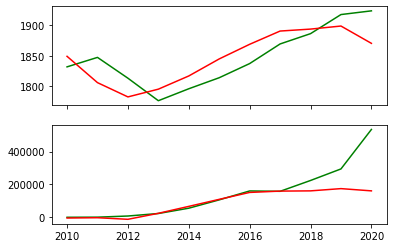

In [455]:
model_layer = [layers.Dense(32, activation= 'sigmoid'),
                layers.GRU(32,activation= 'softsign', recurrent_activation = 'relu', recurrent_dropout = 0.1, dropout = 0.1, return_sequences=False),
                layers.Dense(2)]
EU_X = np.concatenate((EU_em_annual_X[-13:-2, :], EU_veh_X), axis = 1)[:, 1:]
EU_y = np.concatenate((EU_em_annual_y[-13: -2, :], EU_veh_y), axis = 1)
y, EU_y_pred = run_model(EU_X, EU_y, data_memory, epochs, batch_size, model_des, split_point, plot_pred_bool, plot_range, print_summary)
EU_t = np.linspace(2010, 2020, 11)
EU_y = np.concatenate((EU_em_annual_y[-13: -2, :], EU_veh_y), axis = 1)
fig, (ax1, ax2) = plt.subplots(2, 1, sharex= True)
ax1.plot(EU_t, EU_y[:, 0], 'g', EU_t, EU_y_pred[:, 0], 'r')
ax2.plot(EU_t, EU_y[:, 1], 'g', EU_t, EU_y_pred[:, 1], 'r')



Model: "sequential_134"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_489 (Dense)           (23, 5, 32)               832       
                                                                 
 gru_222 (GRU)               (23, 32)                  6336      
                                                                 
 dense_490 (Dense)           (23, 2)                   66        
                                                                 
Total params: 7,234
Trainable params: 7,234
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
20/20 [==============================] - 2s 18ms/step - loss: 0.2724 - val_loss: 1.6365
Epoch 2/20
20/20 [==============================] - 0s 3ms/step - loss: 0.1362 - val_loss: 1.1240
Epoch 3/20
20/20 [==============================] - 0s 3ms/step - loss: 0.0828 - val_loss: 0.7523
Epoch 4/20
20/20 [=

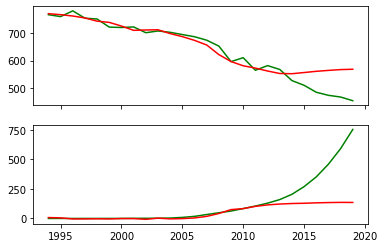

In [401]:
model_layer = [layers.Dense(32, activation= 'sigmoid'),
                layers.GRU(32,activation= 'softsign', recurrent_activation = 'relu', recurrent_dropout = 0.1, dropout = 0.1, return_sequences=False),
                layers.Dense(2)]
UK_X = np.concatenate((UK_em_X[4:, :], UK_veh_X[:-1, :]), axis = 1)[:, 1:]
UK_y = np.concatenate((UK_em_y[4:], UK_veh_y[: -1]), axis = 1)
y, UK_y_pred = run_model(UK_X, UK_y, data_memory, epochs, batch_size, model_des, split_point, plot_pred_bool, plot_range, print_summary = True)
UK_y = np.concatenate((UK_em_y[4:], UK_veh_y[: -1]), axis = 1)
UK_t = np.linspace(1994, 2019, 26)
fig, (ax1, ax2) = plt.subplots(2, 1, sharex= True)
ax1.plot(UK_t, UK_y[:, 0], 'g', UK_t, UK_y_pred[:, 0], 'r')
ax2.plot(UK_t, UK_y[:, 1], 'g', UK_t, UK_y_pred[:, 1], 'r')


Epoch 1/50
22/22 [==============================] - 2s 18ms/step - loss: 1.0437 - val_loss: 1.1985
Epoch 2/50
22/22 [==============================] - 0s 5ms/step - loss: 0.7593 - val_loss: 0.7991
Epoch 3/50
22/22 [==============================] - 0s 5ms/step - loss: 0.6104 - val_loss: 0.5846
Epoch 4/50
22/22 [==============================] - 0s 7ms/step - loss: 0.3335 - val_loss: 0.2527
Epoch 5/50
22/22 [==============================] - 0s 5ms/step - loss: 0.3853 - val_loss: 0.4165
Epoch 6/50
22/22 [==============================] - 0s 4ms/step - loss: 0.2093 - val_loss: 0.4110
Epoch 7/50
22/22 [==============================] - 0s 4ms/step - loss: 0.2499 - val_loss: 0.3609
Epoch 8/50
22/22 [==============================] - 0s 3ms/step - loss: 0.1521 - val_loss: 0.5303
Epoch 9/50
22/22 [==============================] - 0s 5ms/step - loss: 0.2237 - val_loss: 0.4667
Epoch 10/50
22/22 [==============================] - 0s 6ms/step - loss: 0.3000 - val_loss: 0.5047
Epoch 11/50
22/22 

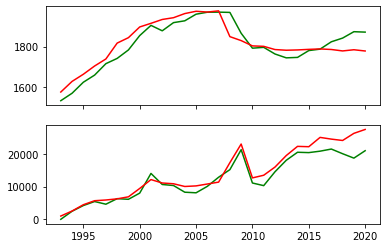

In [403]:
model_layer = [layers.Dense(32, activation= 'sigmoid'),
                layers.GRU(32,activation= 'softsign', recurrent_activation = 'relu', recurrent_dropout = 0.1, dropout = 0.1, return_sequences=False),
                layers.Dense(2)]
epochs = 50
US_X = np.concatenate((US_em_X[2:, :15], US_veh_X), axis = 1)
US_y = np.concatenate((US_em_y[2:, :15], US_veh_y), axis = 1)
y, US_y_pred = run_model(US_X, US_y, data_memory, epochs, batch_size, model_des, split_point, plot_pred_bool, plot_range, print_summary)

US_y = np.concatenate((US_em_y[2:, :15], US_veh_y), axis = 1)
US_t = np.linspace(1993, 2020, 28)
plt.figure(1)
fig, (ax1, ax2) = plt.subplots(2, 1, sharex= True)
ax1.plot(US_t, US_y[:, 0], 'g', US_t, US_y_pred[:, 0], 'r')
ax2.plot(US_t, US_y[:, 1], 'g', US_t, US_y_pred[:, 1], 'r')

70.46691


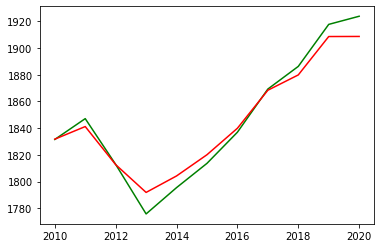

In [454]:
regr = RandomForestRegressor(n_estimators = 100, max_depth=3)
regr.fit(EU_X, EU_y[:, 0])
np.array([EU_X[0, :]])
EU_y_reg = np.zeros(EU_X.shape[0])
for i in range(EU_X.shape[0]):
    EU_y_reg[i] = regr.predict(np.array([EU_X[i, :]]))
EU_t = np.linspace(2010, 2020, 11)
plt.plot(EU_t, EU_y[:, 0], 'g', EU_t, EU_y_reg, 'r')
mse = metrics.MeanSquaredError()
mse.update_state(EU_y[:, 0], EU_y_reg)
test_loss = mse.result().numpy()
print(test_loss)

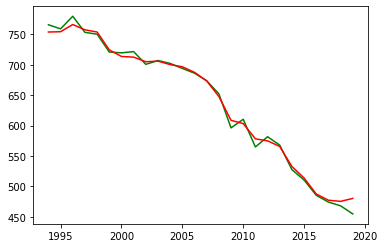

In [439]:
regr = RandomForestRegressor(max_depth=3, random_state=0)
regr.fit(UK_X, UK_y[:, 0])
np.array([UK_X[0, :]])
UK_y_reg = np.zeros(UK_X.shape[0])
for i in range(UK_X.shape[0]):
    UK_y_reg[i] = regr.predict(np.array([UK_X[i, :]]))
UK_t = np.linspace(1994, 2019, 26)
plt.plot(UK_t, UK_y[:, 0], 'g', UK_t, UK_y_reg, 'r')

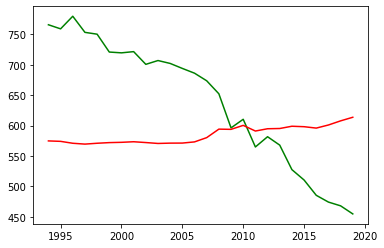

In [307]:
EU_em_X, EU_em_y = np.split(EU_em_df.to_numpy(), [11], 1)
UK_em_X, UK_em_y = np.split(UK_em_df.to_numpy(dtype=np.float64), [13], 1)
US_em_X, US_em_y, a = np.split(US_em_df.to_numpy(dtype=np.float64), [45,46], 1)
EU_veh_X = EU_veh_df.to_numpy()
EU_veh_y = np.roll(np.sum(EU_veh_X[:, 1:3], axis =1), time_step)
EU_veh_y[:time_step] = 0
EU_veh_y = np.array([EU_veh_y]).transpose()
UK_veh_X = UK_veh_df.to_numpy(dtype=np.float64)
UK_veh_X = UK_veh_df.to_numpy(dtype=np.float64)
UK_veh_y = np.array([np.sum(UK_veh_X[:, 3:7], axis = 1)]).transpose()
US_veh_X, US_veh_y = np.split(US_veh_df.to_numpy(dtype=np.float64), [8], 1)
EU_em_annual_X, EU_em_annual_y = np.split(EU_em_df.groupby(np.concatenate((np.repeat(np.linspace(1973, 2020, 48, dtype = np.int64), 12), 2021 *np.ones((10), dtype=np.int64)), axis = 0)).sum().to_numpy(), [11], 1)
EU_X = np.concatenate((EU_em_annual_X[-13:-2, :], EU_veh_X), axis = 1)
EU_y = np.concatenate((EU_em_annual_y[-13: -2, :], EU_veh_y), axis = 1)
UK_X = np.concatenate((UK_em_X[4:, :], UK_veh_X[:-1, :]), axis = 1)
UK_y = np.concatenate((UK_em_y[4:], UK_veh_y[: -1]), axis = 1)
US_X = np.concatenate((US_em_X[2:, :15], US_veh_X), axis = 1)
US_y = np.concatenate((US_em_y[2:, :15], US_veh_y), axis = 1)


US_t = np.linspace(1993, 2020, 28)

plt.plot(UK_t, UK_y[:, 0], 'g', UK_t, UK_y_pred[:, 0], 'r')


#plot_pred(UK_veh_y[:, 0], y_pred, plot_range)

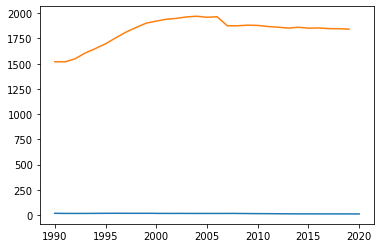

In [8]:
UK_em_df.shape
t = np.linspace(1990, 2020, 30, endpoint=True)
plt.plot(t, UK_em_X[:, -2])
t = np.linspace(1990, 2019, 30)
plt.plot(t, np.roll(y_pred, 0))

In [359]:
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Dense(units=hp.Int("dense_units", min_value=16, max_value=128, step=16)))
    model.add(layers.GRU(units=hp.Int("GRU_units", min_value=16, max_value=128, step=16), activation='sigmoid', recurrent_activation='sigmoid'))
    model.add(layers.Dense(1))
    model.compile(optimizer='adam', loss = 'mse')
    return model
val_split = int(x_train.shape[0] * 0.9)
x_train_val, x_val, y_train_val, y_val = train_test_split(x_train, y_train, val_split)
tuner = kt.RandomSearch(
    hypermodel=build_model,
    objective="val_loss",
    max_trials=3,
    executions_per_trial=2,
    overwrite=True,
    directory="RNN_em",
    project_name="RNN_em",
    )

tuner.search(x_train, y_train, epochs=2, validation_data=(x_val, y_val))
models = tuner.get_best_models(num_models=2)
best_model = models[0]
input_shape = (x_train.shape[0], data_memory, samples)
best_model.build(input_shape=input_shape)
best_model.summary()
tuner.results_summary()
# Get the top 2 hyperparameters.
best_hps = tuner.get_best_hyperparameters(5)
# Build the model with the best hp.
model = build_model(best_hps[0])
history = model.fit(x=x_train, y=y_train, epochs=10)

Trial 3 Complete [00h 00m 07s]
val_loss: 0.1846400871872902

Best val_loss So Far: 0.1846400871872902
Total elapsed time: 00h 00m 25s
INFO:tensorflow:Oracle triggered exit
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (439, 5, 64)              768       
                                                                 
 gru (GRU)                   (439, 80)                 35040     
                                                                 
 dense_1 (Dense)             (439, 1)                  81        
                                                                 
Total params: 35,889
Trainable params: 35,889
Non-trainable params: 0
_________________________________________________________________
Results summary
Results in RNN_em\RNN_em
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
dense

ValueError: x and y must have same first dimension, but have shapes (20,) and (0, 1)

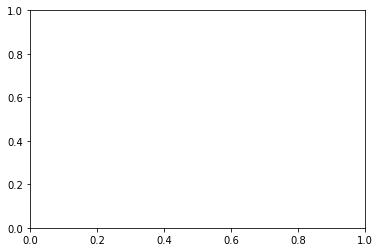

In [360]:
plot_range = [80]
plot_range += [plot_range[0] + 20]
t = np.linspace(plot_range[0], plot_range[1], plot_range[1] - plot_range[0])
plt.plot(t, y[plot_range[0] : plot_range[1]], 'g', t, y_pred[plot_range[0]: plot_range[1]], 'r')